<a href="https://colab.research.google.com/github/SERVIR/flood_mapping_intercomparison/blob/main/notebooks/Module_1_Data_Availability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

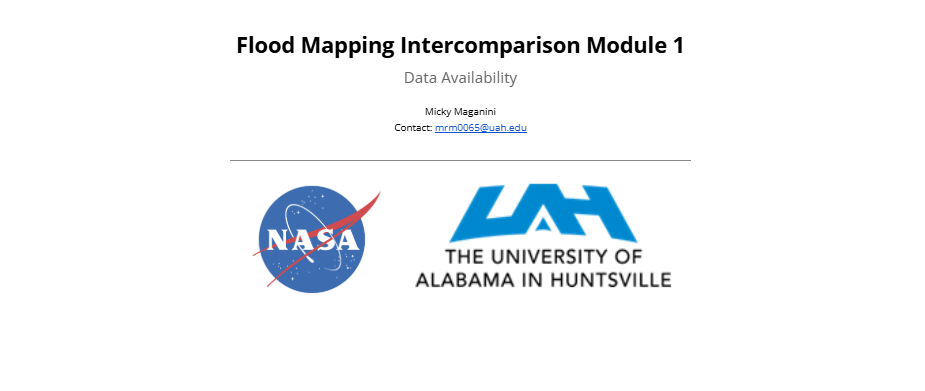

# **Prerequisites**

Before taking this module, you must have the following

* A Google Earth Engine Account
* A Google Cloud Project tied to your Google Earth Engine account.
* A Google Drive account.
* Google Colaboratory installed on your Google Drive

# **Introduction**

In this module, we will determine the availability of cloud-free optical data as well as Sentinel-1 Synthetic Aperture Radar (SAR) data for a flood event of your interest. We are searching for a flood event in which there is a...

- Sentinel-1 overpass over the area of interest during the time of interest
- Harmonized Landsat and Sentinel-2 (HLS) overpass over the area of interest during the time of interest
- low prevalence of cloud in all optical sensors used to create flood products (HLS, MODIS, VIIRS).

If we find a suitable flood event, we will export the area within the area of interest in which there is an overlap between the HLS and Sentinel-1 overpass geometries. Please note that this script is written with the intention of intercomparing floods where we have both a Sentinel-1 and an HLS overpass.

## **Step 1: Create GEE Directory**

- 1. Open the [Google Earth Engine Code Editor](https://code.earthengine.google.com/)

- 2. Navigate to the Assets Tab in the upper right.

- 3. Create a new folder by clicking the "New" Button. Enter in a name or path for the folder. **This will be our parent directory, and will be where we upload all of the flood products**. My parent folder is called "users/mickymags/flood_intercomparison", but you can call yours whatever you like.

# Step 2: Define Inputs

After modifying the cells below to suit your case study and Earth Engine account, the rest of the cells should run as is.

To define our area of interest, we will type in the country name and either a list of provinces our a list of counties. The country name and province/county names must match the spelling as they appear in the [Global Administrative Unit Layers dataset](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_SIMPLIFIED_500m_2015_level2)

In [ ]:
# Google Earth Engine Variables
parent_directory = "users/mickymags/oct_cambodia/"                                               # Define the path to the directory you created in step 1. This will either begin with "users/..." or "projects/...""
aoi_asset_name = 'aoi'                                                                           # Define what you want the asset name of your area of interest to be
gee_project_name = "servir-sco-assets"                                                           # Type in the name of your Google Earth Engine Project.
my_Gdrive_folder = "drive/My Drive/Flood_Intercomparison/Case_Studies/oct/oct_cambodia/"         # Type in the path to a Google Drive folder you would like to store data in. Keep "/content/drive/MyDrive/ intact, but you can create a custom path after that. Make sure this ends in a slash."

# Case Study Variables
doi = "2024-10-01"                                                                 # Enter the Date of Interest in "YYYY-MM-DD"
country = 'Cambodia'                                                               # Enter country name as a string
province_list = 'Battambang,Kampong Cham,Kampong Chhnang,Kampong Thom,Pursat'      # Leave this as an empty string if using district_list
district_list = ''                                                                 # Leave this as an empty string if using province_list
flood_event_desc = 'Cambodia_test'                                                 # Enter in a description of your flood event

# Step 3: Import packages

We need to import a couple packages for this analysis.

1. The Earth Engine package will allow us to obtain data from Earth Engine and perform some operations on the data.
2. The [geemap](https://geemap.org/) Python package allows for further analysis and visualization using Earth Engine data.
3. The Google Drive package will allow us to export imagery and data from this notebook to your Google Drive.


In [ ]:
from google.colab import drive       # Import Google Drive
import ee                            # Import the Earth Engine package
import geemap                        # Import the Google Earth Engine Python package (geemap)
import os

Now we need to Authenticate Earth Engine, and initilaze it. After running the following cell, a popup window will appear. Follow the instructions therein to complete the initialization of Github.

In [ ]:
ee.Authenticate()
ee.Initialize(project = gee_project_name)

# Step 4: Get input data


In [ ]:
drive.mount('/content/drive/')

In [ ]:
pwd

In [ ]:
# Navigate into the defined Google Drive folder
gdrive_split = my_Gdrive_folder.split('/')[:-1]
gdrive_split

for i in gdrive_split:
  stri = str(i)
  if os.path.isdir(stri) == True:      #if folder already exists, enter into it
    os.chdir(stri)
  else:                                # if folder doeesn't yet exist, create it, then enter it.
    os.mkdir(stri)
    os.chdir(stri)

For this project, we want to compare six flood products/software to each other. Some of these have different input datasets from optical and SAR sensors, which we detail below. In this notebook, we will examine the quality assurance infromation from all of the input datasets to determine if a case study is suitable for optical analysis.


* GFM: The Copernicus Global Flood Monitor. For more information see [this website](https://global-flood.emergency.copernicus.eu/technical-information/glofas-gfm/).
  * Input Dataset: Sentinel-1 uses IW GRDH product, which we can obtain from Google Earth Engine
*  TERRA: The Terra product used as input to the MCDWD product has the following DOI (http://doi.org/10.5067/MODIS/MOD09.NRT.061) (Slayback et al 2024). This product is not available in GEE. Thus, we will use a similar MODIS product in order to estimate the cloud cover in the region of interest
* AQUA: The Aqua product used as input to the MCDWD product is not specified. Email sent 09/05/24
* HLS: The HLS product is split into two datasets, one for Sentinel and one for Landsat. The Sentinel HLS product is not currently available on GEE.



In [ ]:
sentinel1 = ee.ImageCollection("COPERNICUS/S1_GRD")      # Sentinel-1 Ground Range Detected
hls_landsat = ee.ImageCollection("NASA/HLS/HLSL30/v002")
s2 = ee.ImageCollection("NASA/HLS/HLSS30/v002")          #s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
terra = ee.ImageCollection("MODIS/061/MOD09GA")
aqua = ee.ImageCollection("MODIS/061/MYD09GA")
viirs = ee.ImageCollection("NASA/VIIRS/002/VNP09GA")

Let's filter the Sentinel-1 collection to just those images that are used by the GFM flood Product. GFM ingests observations from the Sentinel-1 satellites that are acquired in the Interferometric Wide-swath (IW imaging mode) (Matgen et al 2022). GFM uses the Ground Range Detected at High Resolution (GRDH) product from Sentinel-1 to create the GFM Water Product (Matgen et al 2021).

In [ ]:
# Sentinel-1 Filtered to interferometric width
s1filt = sentinel1.filter(ee.Filter.eq('instrumentMode', 'IW'))\
                  .filter(ee.Filter.eq('resolution', 'H'))          # Filter to High Resolution Scenes

Get the day after our day of interest so we can filter our image collections to coincide with our date of interest.

In [ ]:
dayafter = ee.Date(doi).advance(1, "day")

Get an area of interest

In [ ]:
gaul = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")

In [ ]:
def region_merger_v1(my_country, my_provinces):
  '''
  region_merger_v1 should be used if your area of interest is defined by one or multiple Level 1 administrative boundaries (i.e. states or provinces)
  my_country = a string defining a country, case sensitive, as spelled within FAO's Global Administrative Unit Layers datasets. Only one country is supported.
  my_provinces = a string defining one or multiple level 1 administrative boundaries found within my_country,
    as spelled within FAO's Global Administrative Unit Layers dataset. If multiple provinces are defined, separate them with a comma (no spaces).
  '''
  area_of_interest = ee.FeatureCollection([])

  country = gaul.filter(ee.Filter.eq("ADM0_NAME", my_country))

  splitstring = my_provinces.split(",")
  feature_list = []
  for y in splitstring:
    feature = country.filter(ee.Filter.eq("ADM1_NAME", y))
    feature_list.append(feature)
  for x in feature_list:
    area_of_interest = area_of_interest.merge(x)

  return area_of_interest

In [ ]:
def region_merger_v2(my_country, my_state, my_district_string):
  '''
  region_merger_v2 should be used if your area of interest is defined by one or multiple Level 2 administrative boundaries (i.e. districts or counties)
  my_country = a string defining a country, case sensitive, as spelled within FAO's Global Administrative Unit Layers datasets. Only one country is supported.
  my_state = an empty string
  my_district_string = a string defining one or multiple level 2 administrative boundaries found within my_country,
    as spelled within FAO's Global Administrative Unit Layers dataset. If multiple districts are defined, separate them with a comma (no spaces).
  '''

  # Create an empty feature collection
  area_of_interest = ee.FeatureCollection([])

  # Filter the GAUL dataset to the user-defined region of interest
  country = gaul.filter(ee.Filter.eq("ADM0_NAME", my_country))
  state = country.filter(ee.Filter.eq("ADM1_NAME", my_state))

  # Split the string by commas
  splitstring = my_district_string.split(",")

  # Create empty feature list
  feature_list = []

  # for entries in the split string list...
  for y in splitstring:
    feature = state.filter(ee.Filter.eq("ADM2_NAME", y))   # Filter to the district of interest
    feature_list.append(feature)                           # Append the feature to the feature list
  for x in feature_list:                                   # For each feature in the list, merge the area of interest
    area_of_interest = area_of_interest.merge(x)

  return area_of_interest                                  # Return the area of interest

In [ ]:
# If the province list is empty, run region_merger_v2. If it is not empty, run region_merger_v1
if province_list == '':
  aoi = region_merger_v2(country, province_list, district_list)
else:
  aoi = region_merger_v1(country, province_list)

Let's print the aoi to the console to make sure that it contains our provinces. If you see "Feature Collection (0 elements...)", that means something went wrong. Check the spelling of your country, district, and provinces.

If you see "FeatureCollection (x elements...)" where x > 0, the code is working as intended. You can click the dropdown arrow to expand the collection and make sure it has all your provinces.

In [ ]:
aoi

In [ ]:
# Get the coordinates of the center of the AOI for mapping purposes
aoi_centroid = aoi.geometry().centroid()             # Get the center of the AOI
lon = aoi_centroid.coordinates().get(0).getInfo()    # Extract the longitude from the centroid
lat = aoi_centroid.coordinates().get(1).getInfo()    # Extract the latitude from the centroid

In [ ]:
# Filter sentinel-1 to the dates and region of interest
s1final = s1filt.filterDate(doi, dayafter).filterBounds(aoi)

In [ ]:
# Extract the geometry of the Sentinel-1 geometry.
s1geom = s1final.geometry()

In [ ]:
# Merge the HLS Sentinel and HLS Landsat Image Collections
hls = s2.merge(hls_landsat)

# Filter the HLS collection to the day and region of interest
hls_final = hls.filterDate(doi, dayafter).filterBounds(aoi)

# Get the geometry of the above collection
hls_geom = hls_final.geometry()

Now we will define aoifinal, the final area of interest. this is the intersection of where our HLS overpass and our Sentinel-1 overpass is.

In [ ]:
aoifinal = hls_geom.intersection(s1geom)

let's print the intersected area below to make sure it has multiple vertices.

In [ ]:
aoifinal

In [ ]:
s1_mosaic = s1final.mosaic()  # Mosaic Image Collection into a single image

In [ ]:
# Define some visualization parameters for Sentinel-1
s1vv_vp = {
    'bands': ['VV', 'VV', 'VV'], # All bands as VV to create gray-scale image
    'min': - 25,                 # minimum
    'max': 0                     # maximum
}

In [ ]:
Map = geemap.Map(center = (lat, lon), zoom = 5)
Map.addLayer(aoi, {}, 'region of interest')                                          # Add original area of interest to the map
Map.addLayer(s1geom, {}, 'Sentinel-1 Geometry')                                      # Add Sentinel-1 footprint to the map
Map.addLayer(hls_geom, {}, 'HLS Geometry')                                           # Add Harmonized Landsat Sentinel footprint to the map
Map.addLayer(aoifinal, {}, 'Final Area of Interest -- intersection of HLS and S1')   # Add intersection of S1 and HLS footprints to the map
Map.addLayer(s1_mosaic, s1vv_vp, 'Sentinel1 VV')                                     # Add Sentinel-1 mosaic to the map

Map.addLayerControl()                                                                # Add the ability to toggle layers on and off
Map

In [ ]:
# Create a bounding box around the area of interest
aoibb = aoifinal.bounds()

In [ ]:
aoifc = ee.FeatureCollection(aoifinal)
aoibb_fc = ee.FeatureCollection(aoibb)

In [ ]:
# Export AOI and Bounding Box to Google Drive
geemap.ee_export_vector_to_drive(aoifc, description='drive_export_aoi'+flood_event_desc,folder= my_Gdrive_folder.split('/')[-2],fileFormat='GeoJSON')
geemap.ee_export_vector_to_drive(aoibb_fc, description='drive_export_bbox_aoi'+flood_event_desc,folder=my_Gdrive_folder.split('/')[-2],fileFormat='GeoJSON')

# Export AOI and Bounding Box to Google Drive
geemap.ee_export_vector_to_asset(aoifc, description='exporting_final_aoi'+flood_event_desc, assetId= parent_directory + 'aoi')
geemap.ee_export_vector_to_asset(aoibb_fc, description='exporting_final_aoi_bbox'+flood_event_desc, assetId= parent_directory + 'aoi_bbox')

The area of interest and its bounding box will now be available in Google Drive, under the Flood_Intercomparison folder. They will also be available in Google Earth Engine, under the folder you defined in Step 1. You can check the status of these exports by clicking "Tasks" in the upper right corner of the [Google Earth Engine Code Editor](https://code.earthengine.google.com/). Once the exports are complete, you can now move to Module 2.

# References


- Matgen, Patrick. "Provision of an Automated, Global, Satellite-based Flood Monitoring Product for the Copernicus Emergency Management Service. "GFM D6 Product Definition Document. Issue 1 Version 1.4. April 20, 2022.

- Slayback, Dan. MODIS NRT Global Flood Product User Guide. Revision D. NASA LANCE, 16 April 2024. https://www.earthdata.nasa.gov/s3fs-public/2024-04/MCDWD_UserGuide_RevD.pdf

- Roger, J.C. et al. "Suomi-NPP VIIRS Surface Reflectance User's Guide". NASA Land SIPS. Version 2.0. April 2023. https://lpdaac.usgs.gov/documents/1657/VNP09_User_Guide_V2.pdf
